In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

from glob import glob
from skimage import io, color, measure, segmentation, morphology
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

In [2]:
def load_image_and_mask(image_id_path):

    img_path = glob(os.path.join(image_id_path, "images", "*"))[0]
    image = io.imread(img_path)

    mask_paths = glob(os.path.join(image_id_path, "masks", "*"))

    combined_mask = np.zeros(image.shape[:2], dtype=np.uint8)

    for m in mask_paths:
        mask = io.imread(m)
        if mask.ndim == 3:
            mask = mask[..., 0]
        combined_mask = np.maximum(combined_mask, mask)

    return image, combined_mask

In [11]:
def preprocess(image):

    if image.ndim == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image

    # Denoising (better than Gaussian alone)
    gray = cv2.fastNlMeansDenoising(gray, None, 10, 7, 21)

    # CLAHE contrast boost
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)

    # Otsu threshold
    _, binary = cv2.threshold(
        gray, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # Polarity correction
    if np.mean(binary) > 127:
        binary = 255 - binary

    # Morphological cleanup
    kernel = np.ones((3,3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

    return gray, binary

In [4]:
def get_gradient(gray):
    gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    grad = np.sqrt(gx**2 + gy**2)
    return grad

In [5]:
def naive_watershed(gray, binary):

    gradient = get_gradient(gray)

    markers = measure.label(binary > 0)

    labels = segmentation.watershed(
        gradient,
        markers,
        mask=(binary > 0)
    )

    return labels

In [6]:
def marker_watershed(gray, binary):

    distance = ndi.distance_transform_edt(binary)

    coords = peak_local_max(
        distance,
        min_distance=8,
        threshold_rel=0.2,
        labels=binary
    )

    markers = np.zeros(distance.shape, dtype=int)

    for i, coord in enumerate(coords, start=1):
        markers[coord[0], coord[1]] = i

    gradient = get_gradient(gray)

    labels = segmentation.watershed(
        gradient,
        markers,
        mask=binary
    )

    return labels

In [7]:
def remove_small(labels, min_size=40):
    return morphology.remove_small_objects(labels.astype(int), min_size)

def dice(gt, pred):
    gt = gt > 0
    pred = pred > 0
    return 2*np.sum(gt & pred) / (np.sum(gt)+np.sum(pred)+1e-8)

def iou(gt, pred):
    gt = gt > 0
    pred = pred > 0
    return np.sum(gt & pred) / (np.sum(gt | pred)+1e-8)

def count_instances(mask):
    return measure.label(mask>0).max()

def overlay(image, labels):
    if image.ndim == 2:
        image = np.stack([image]*3, axis=-1)
    return color.label2rgb(labels, image=image, bg_label=0)

C:\Users\venka\AppData\Local\Temp\ipykernel_6184\887981819.py:2: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  return morphology.remove_small_objects(labels.astype(int), min_size)


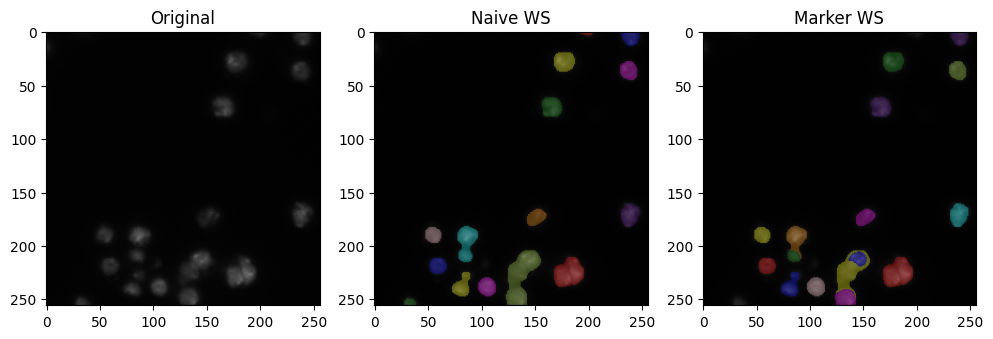

C:\Users\venka\AppData\Local\Temp\ipykernel_6184\887981819.py:2: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  return morphology.remove_small_objects(labels.astype(int), min_size)


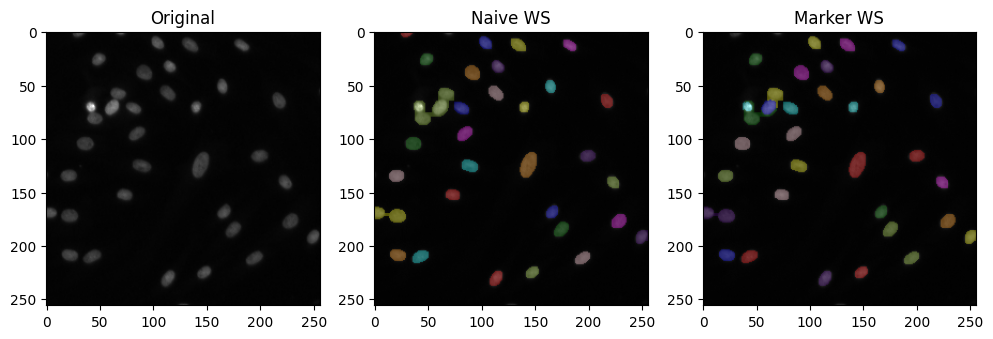

C:\Users\venka\AppData\Local\Temp\ipykernel_6184\887981819.py:2: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  return morphology.remove_small_objects(labels.astype(int), min_size)


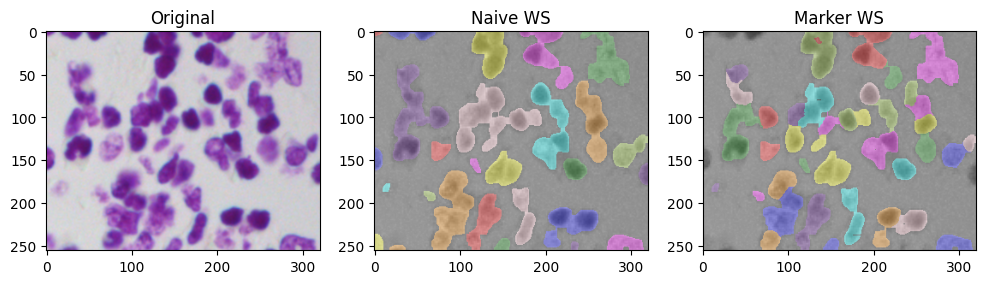

C:\Users\venka\AppData\Local\Temp\ipykernel_6184\887981819.py:2: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  return morphology.remove_small_objects(labels.astype(int), min_size)


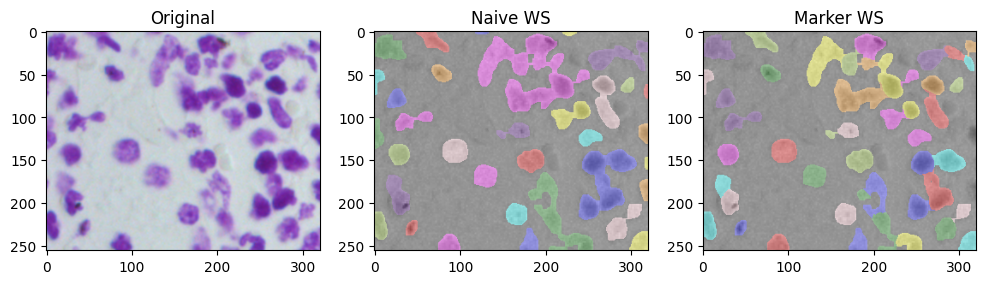

C:\Users\venka\AppData\Local\Temp\ipykernel_6184\887981819.py:2: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  return morphology.remove_small_objects(labels.astype(int), min_size)


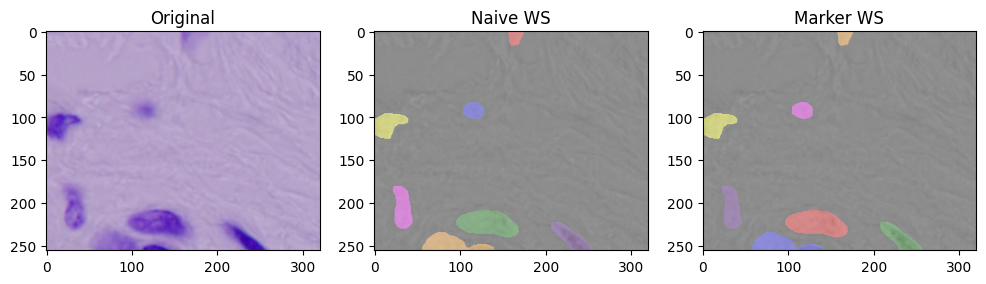

===== AVERAGE PERFORMANCE =====
Mean Dice (Naive) : 0.8568212341336849
Mean Dice (Marker): 0.8469808157486511
Mean IoU (Naive)  : 0.7557071223071213
Mean IoU (Marker) : 0.7410828974117892


In [9]:
TRAIN_PATH = r"C:\deep learning for medical imaging\stage1_train"
ids = os.listdir(TRAIN_PATH)[:5]

dice_naive_scores = []
dice_marker_scores = []

iou_naive_scores = []
iou_marker_scores = []

for image_id in ids:

    path = os.path.join(TRAIN_PATH, image_id)

    image, gt_mask = load_image_and_mask(path)

    gray, binary = preprocess(image)

    naive = naive_watershed(gray, binary)
    marker = marker_watershed(gray, binary)

    naive = remove_small(naive)
    marker = remove_small(marker)

    # metrics
    d_naive = dice(gt_mask, naive)
    d_marker = dice(gt_mask, marker)

    i_naive = iou(gt_mask, naive)
    i_marker = iou(gt_mask, marker)

    dice_naive_scores.append(d_naive)
    dice_marker_scores.append(d_marker)

    iou_naive_scores.append(i_naive)
    iou_marker_scores.append(i_marker)

    # visualization
    plt.figure(figsize=(12,6))

    plt.subplot(1,3,1)
    plt.imshow(image[:,:,:3])
    plt.title("Original")

    plt.subplot(1,3,2)
    plt.imshow(overlay(image[:,:,:3], naive))
    plt.title("Naive WS")

    plt.subplot(1,3,3)
    plt.imshow(overlay(image[:,:,:3], marker))
    plt.title("Marker WS")

    plt.show()

print("===== AVERAGE PERFORMANCE =====")
print("Mean Dice (Naive) :", np.mean(dice_naive_scores))
print("Mean Dice (Marker):", np.mean(dice_marker_scores))

print("Mean IoU (Naive)  :", np.mean(iou_naive_scores))
print("Mean IoU (Marker) :", np.mean(iou_marker_scores))